In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import seaborn as sns
import numpy as np
import pandas as pd
import splitfolders
import os

In [6]:
dir_dummy = 'C:\FILE SEB INSTALL ULANG 7 6 2021\KULIAH\Skripsi\deep-learning\dataset'

In [13]:
splitfolders.ratio(
    dir_dummy,
    output='dataset_splitted',
    ratio=(.7, 0.1, 0.2)
)

Copying files: 2600 files [00:04, 588.99 files/s]


In [7]:
split_train = 'dataset_splitted/train'
split_val = 'dataset_splitted/val' 
split_test = 'dataset_splitted/test'

In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=25,
                    brightness_range=(0.5,1.0),
                    shear_range=0.2,
                    zoom_range=(0.8,1.0),
                    fill_mode='nearest',
                    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    split_train,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    split_val,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    split_test,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

Found 1820 images belonging to 26 classes.
Found 260 images belonging to 26 classes.
Found 520 images belonging to 26 classes.


In [18]:
image, label = train_generator.next()

In [19]:
class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

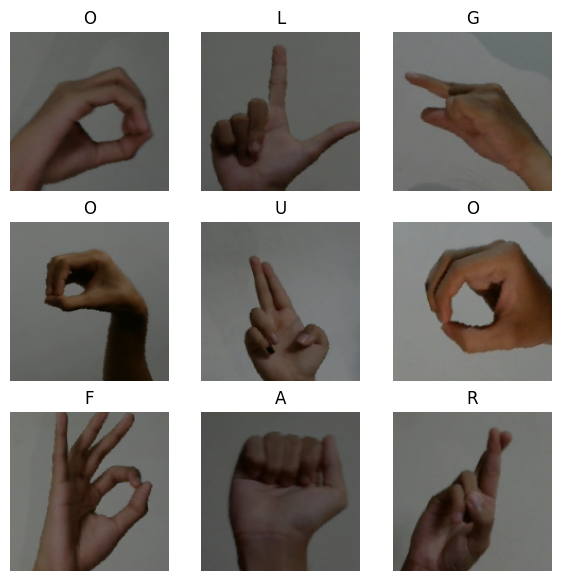

In [20]:
plt.figure(figsize=(7,7))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[i])
  plt.title(class_name[np.argmax(label[i])])
  plt.axis("off")

In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [23]:
from tensorflow import keras
from keras.callbacks import EarlyStopping
monitor_val_accuracy = EarlyStopping(monitor='val_accuracy', patience=3)

In [24]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet',
                                include_top=False,
                                input_shape=(150,150,3))

In [25]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import  Dense, Dropout, GlobalAveragePooling2D

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(tf.keras.layers.Dense(256, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(tf.keras.layers.Dense(128, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(26, activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 26)                6682      
                                                        

In [27]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')> 0.97):
      print("\nAkurasi dan validasi akurasi telah mencapai >97%! Training dihentikan!!")
      self.model.stop_training = True

history = model.fit(train_generator,
                              epochs=20,
                              shuffle=False,
                              verbose=True,
                              validation_data=val_generator,
                              callbacks=[myCallback(), reduce_lr])

Epoch 1/20
57/57 [==============================] - 200s 3s/step - loss: 2.7052 - accuracy: 0.2615 - val_loss: 1.9379 - val_accuracy: 0.4885 - lr: 1.0000e-04
Epoch 2/20
57/57 [==============================] - 181s 3s/step - loss: 1.2050 - accuracy: 0.7011 - val_loss: 0.3600 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 3/20
57/57 [==============================] - 185s 3s/step - loss: 0.3162 - accuracy: 0.9247 - val_loss: 0.0277 - val_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 4/20
57/57 [==============================] - 181s 3s/step - loss: 0.1369 - accuracy: 0.9681 - val_loss: 0.0289 - val_accuracy: 0.9923 - lr: 1.0000e-04
Epoch 5/20
57/57 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9824
Akurasi dan validasi akurasi telah mencapai >97%! Training dihentikan!!

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
57/57 [==============================] - 180s 3s/step - loss: 0.0811 - accuracy: 0.9824 - val_loss: 0.0803 - val_accuracy: 0

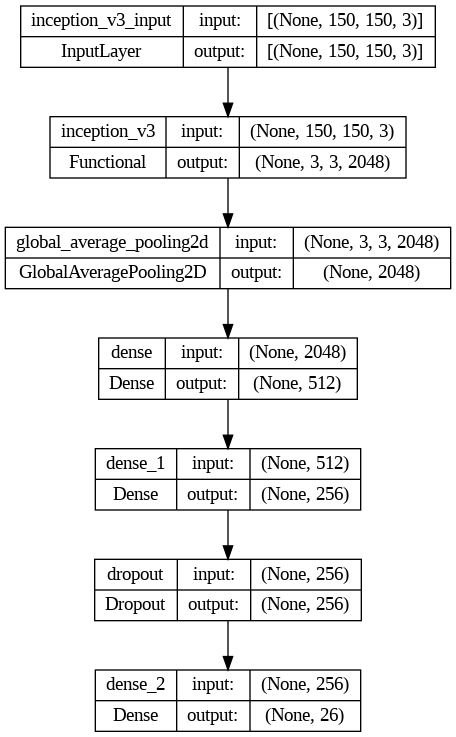

In [23]:
#plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

In [17]:
model.save("Model.h5")

In [18]:
model.save('mymodel.keras')

In [28]:
test_evaluate = model.evaluate(test_generator)

print(f'Test loss     : {test_evaluate[0]}')
print(f'Test accuracy : {round(test_evaluate[1],2)}')

17/17 [==============================] - 13s 736ms/step - loss: 0.0316 - accuracy: 0.9923
Test loss     : 0.031583402305841446
Test accuracy : 0.99


In [2]:
# model = tf.keras.models.load_model('mymodel.keras')
model = tf.keras.models.load_model('Model.h5')

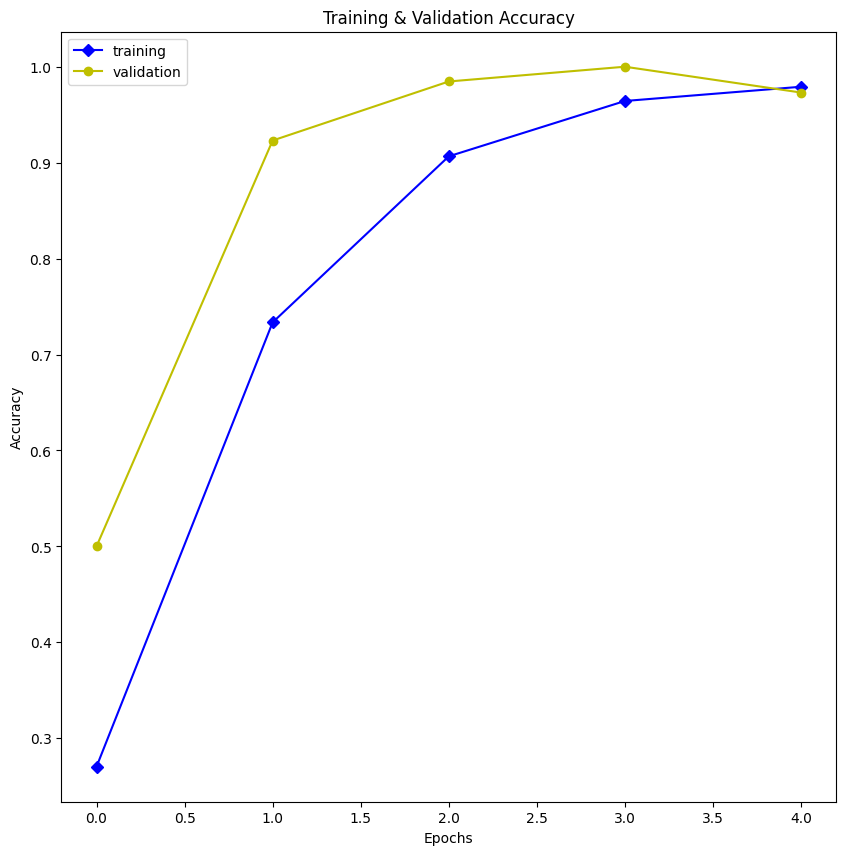

In [21]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'bD-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'yo-',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

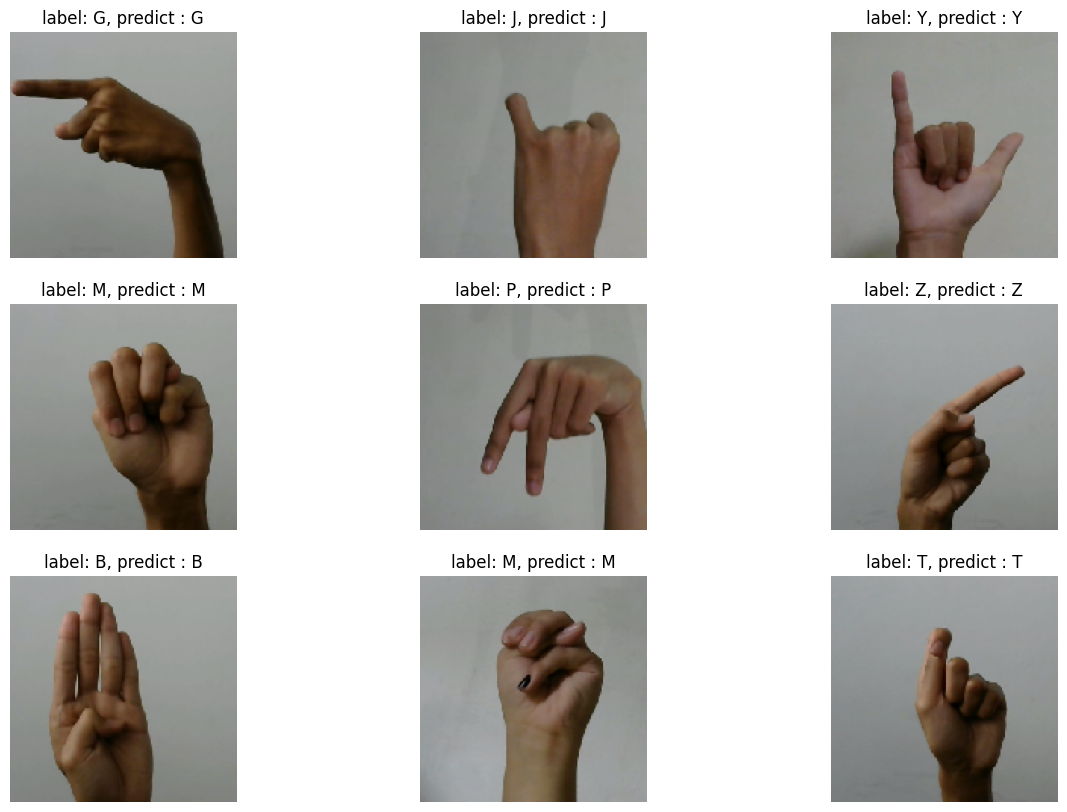

In [29]:
image ,label = next(iter(test_generator)) #mengambil 1 batch data

plt.figure(figsize=(15,10))
for i in range(9) :
    TrueLabel = class_name[np.argmax(label[i])] #mengambil label sesuai dengan index
    plt.subplot(3,3,i+1) #membuat 3 baris 3 kolom
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0)) #mengambil prediksi
    plt.imshow(tf.squeeze(image[i])) #squeeze untuk menghilangkan dimensi 1
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}') #menampilkan label dan prediksi

In [30]:
model.save('models.h5')
model.save('mymodels.keras')

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib

In [26]:
y_test = [] #label test
y_pred = [] # prediksi

for i in range(len(test_generator)) :  #mengambil semua data test
    x,y = test_generator.next() #mengambil 1 batch data
    for j in range(len(y)) : #mengambil semua label
        y_test.append(class_name[tf.argmax(y[j])]) #mengambil label sesuai dengan index
        y_pred.append(class_name[np.argmax(model.predict(x[j][None,...],verbose=0))]) #mengambil prediksi

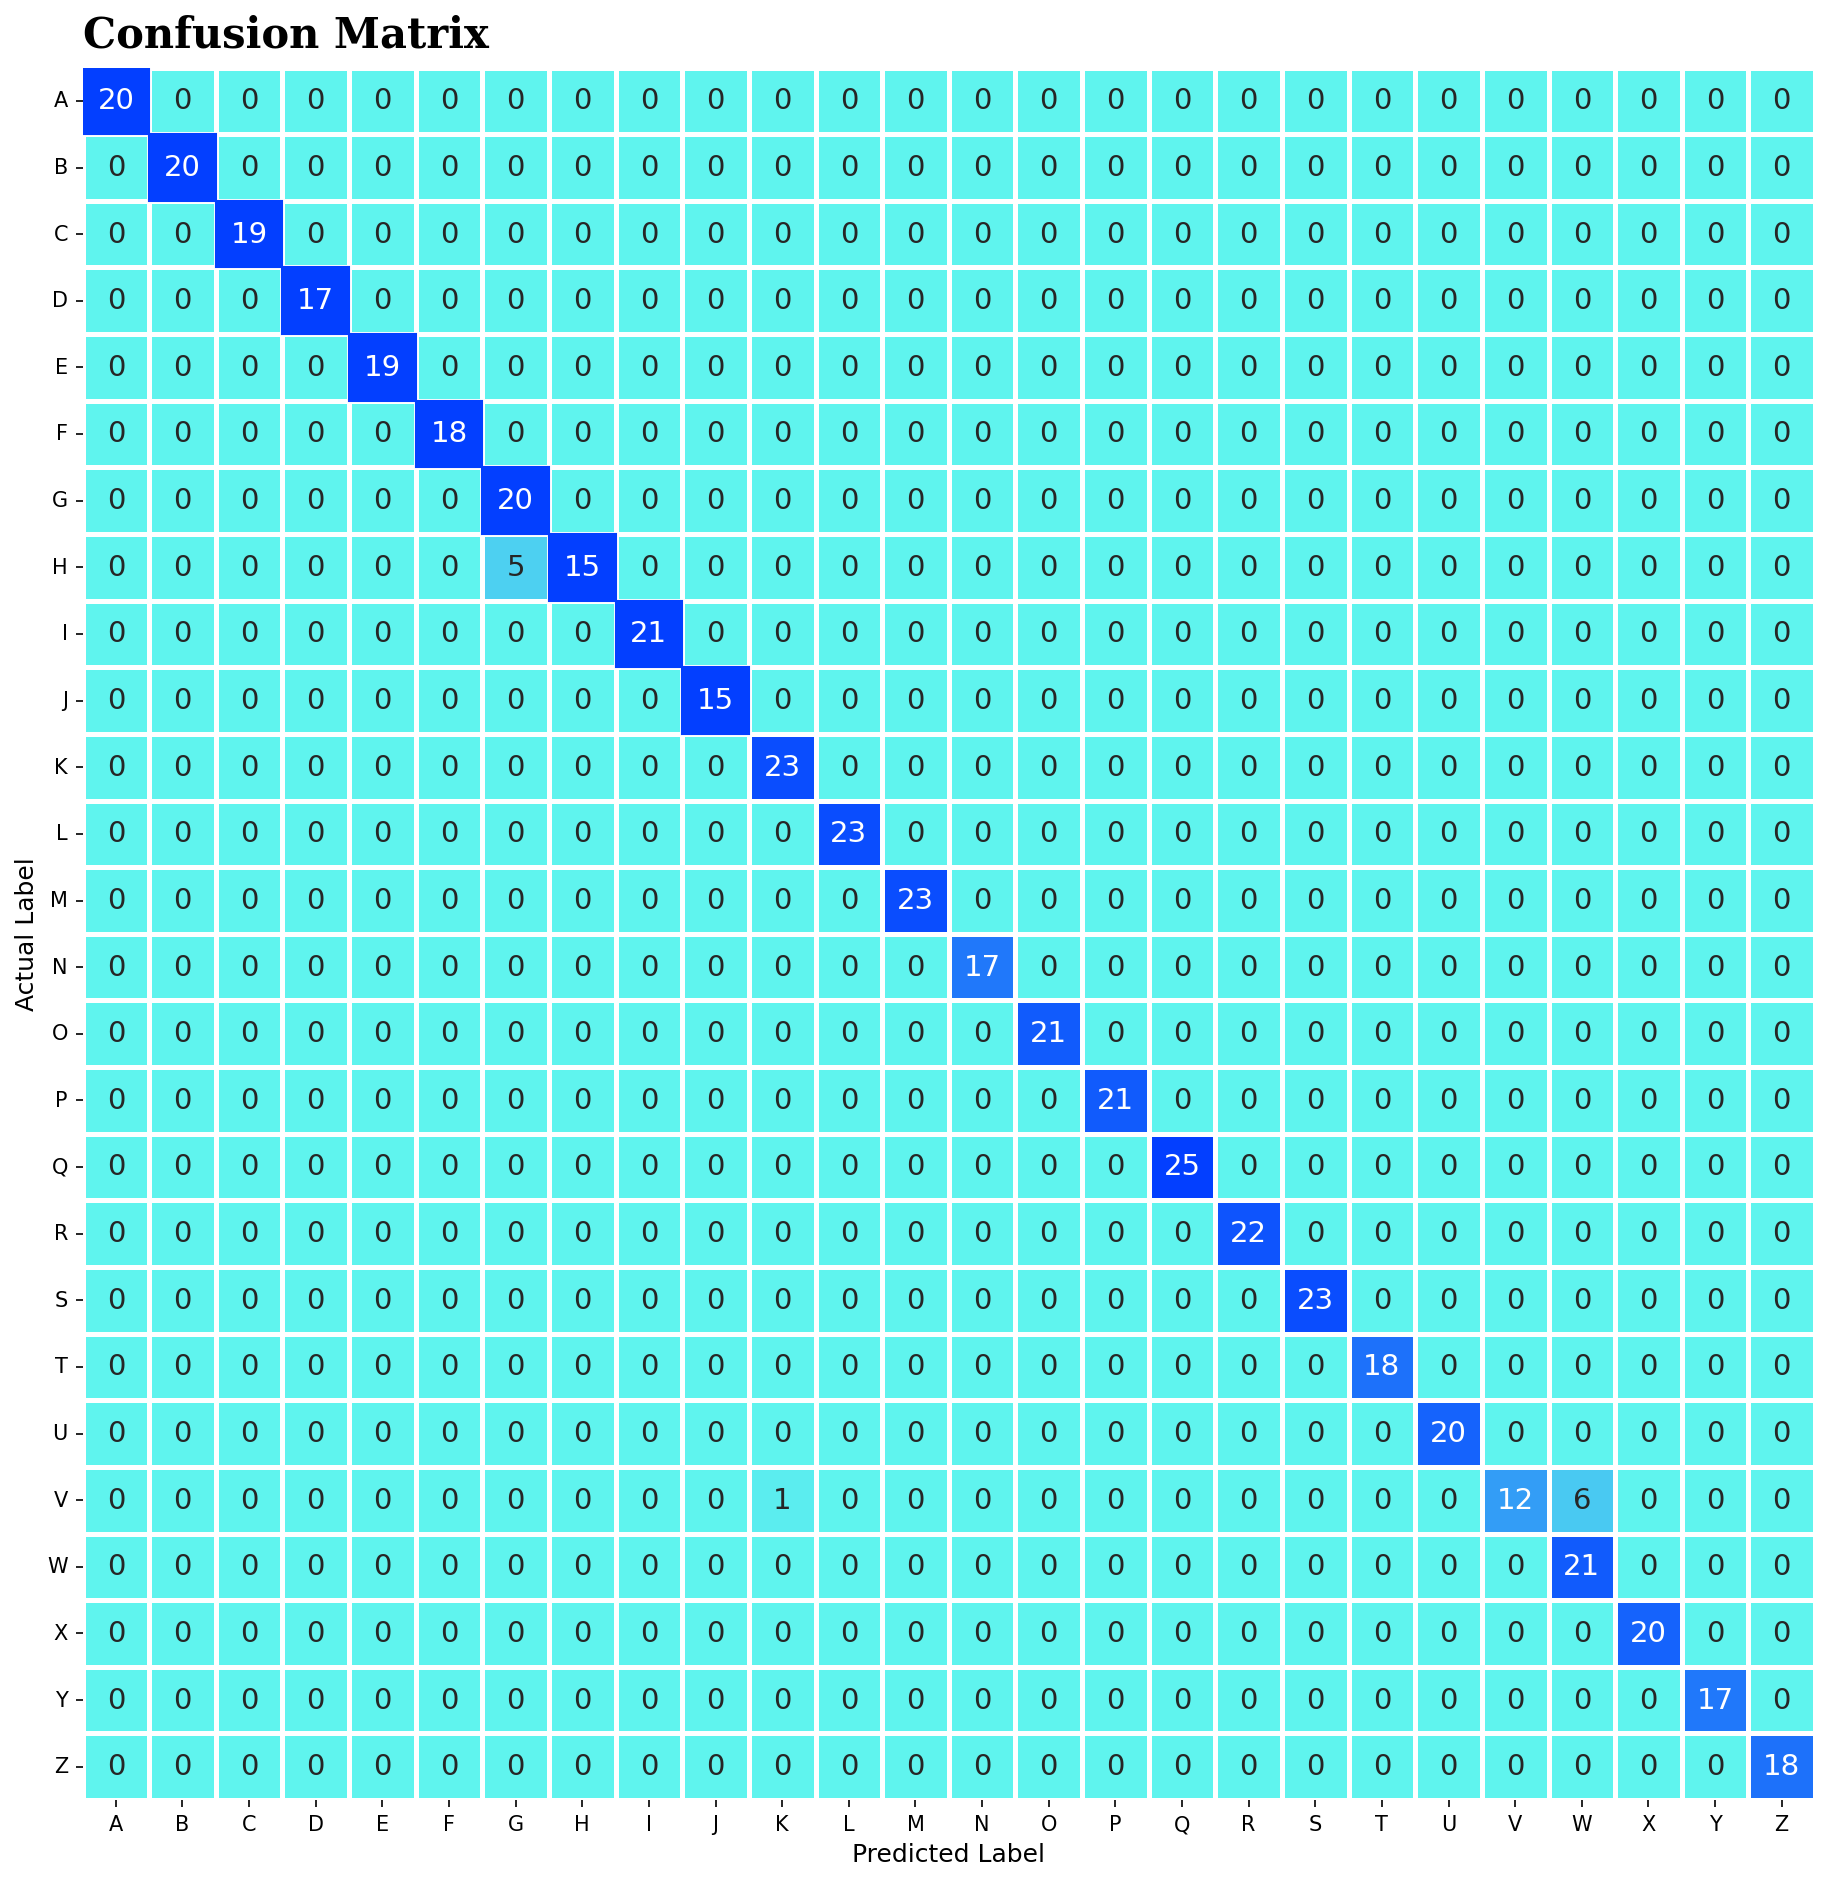

In [28]:
#Confusion Matrix
fig, ax = plt.subplots(figsize=(20, 15),dpi=150)
cm = confusion_matrix(y_test, y_pred) #membuat confusion matrix

colors = ["#5FF4EE","#033FFF"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


ax.text(0,-0.3,'Confusion Matrix ',fontfamily='serif',fontsize=20,fontweight='bold') # judul
sns.heatmap(ax=ax, data=cm,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=1.5, annot=True,cmap=colormap, 
            annot_kws={"fontsize":14},fmt='') #membuat heatmap
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
plt.yticks(rotation=0)

ax.set_ylabel("Actual Label",fontsize=12)
ax.set_xlabel("Predicted Label",fontsize=12)

from matplotlib.patches import Rectangle #membuat kotak
for i in range(0,10): #
    ax.add_patch(Rectangle((i, i), 1, 1, fill=True,color="#033FFF"))

plt.show()

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [30]:
precission = precision_score(y_test, y_pred, pos_label='positive', average='micro') #menghitung presisi
recall = recall_score(y_test, y_pred, pos_label='positive', average='micro') #menghitung recall
f1 = f1_score(y_test, y_pred, pos_label='positive', average='micro')
accuracy = accuracy_score(y_test, y_pred)

c:\Users\nizar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\nizar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\nizar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [32]:
df_classification = pd.DataFrame(
    {
        "Accuracy"  : [accuracy],
        "Precision" : [precission],
        "Recall"    : [recall],
        "f1_score"  : [f1]
    },
    index = ["Model"]
)

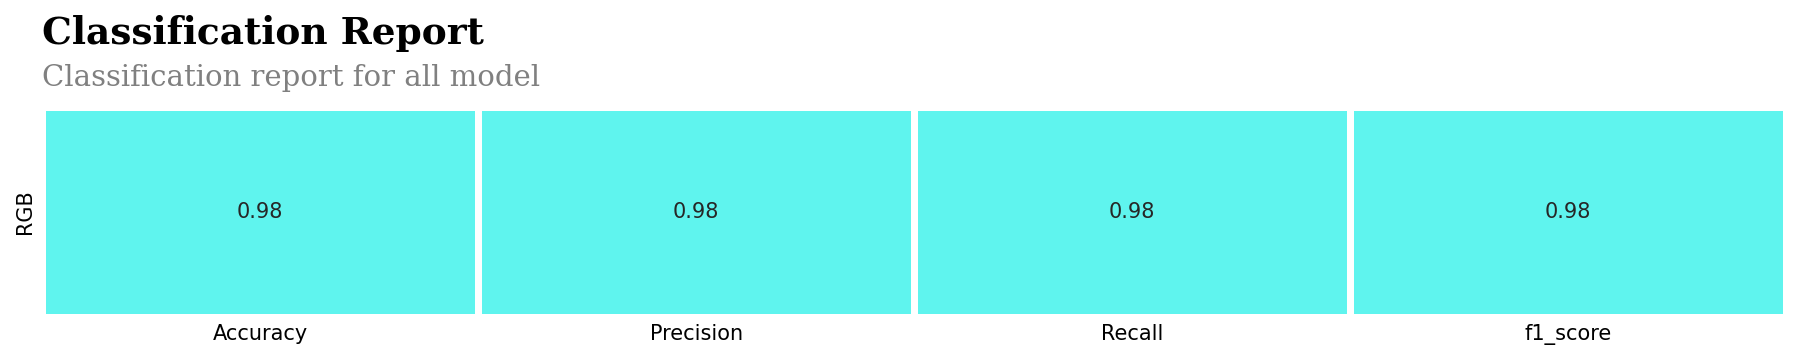

In [33]:
fig = plt.figure(figsize=(15,10), dpi=150)
gs = fig.add_gridspec(4, 4) #membuat grid
gs.update(wspace=0.1, hspace=0.5) #mengatur jarak antar grid
ax0 = fig.add_subplot(gs[0, :]) #membuat subplot

colors = ["#5FF4EE","#4A9FF5"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(df_classification, cmap=colormap,annot=True,fmt=".2f", linewidths=2.5,cbar=False,ax=ax0)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.text(0,-0.30,'Classification Report',fontfamily='serif',fontsize=18,fontweight='bold') #judul
ax0.text(0,-0.10,'Classification report for all model',fontfamily='serif',fontsize=14,fontweight='light',color='gray')#subjudul


rect = ax0.add_patch(Rectangle((0, 1), 4, 1, fill=True,color="#FF8B13",lw=0,alpha=0.8))

plt.show()

In [34]:
print(classification_report(y_test, y_pred, target_names=class_name, digits=3))

              precision    recall  f1-score   support

           A      1.000     1.000     1.000        20
           B      1.000     1.000     1.000        20
           C      1.000     1.000     1.000        19
           D      1.000     1.000     1.000        17
           E      1.000     1.000     1.000        19
           F      1.000     1.000     1.000        18
           G      0.800     1.000     0.889        20
           H      1.000     0.750     0.857        20
           I      1.000     1.000     1.000        21
           J      1.000     1.000     1.000        15
           K      0.958     1.000     0.979        23
           L      1.000     1.000     1.000        23
           M      1.000     1.000     1.000        23
           N      1.000     1.000     1.000        17
           O      1.000     1.000     1.000        21
           P      1.000     1.000     1.000        21
           Q      1.000     1.000     1.000        25
           R      1.000    

In [ ]:
image ,label = next(iter(test_generator)) #mengambil 1 batch data

plt.figure(figsize=(15,10))
for i in range(9) :
    TrueLabel = class_name[np.argmax(label[i])] #mengambil label sesuai dengan index
    plt.subplot(3,3,i+1) #membuat 3 baris 3 kolom
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0)) #mengambil prediksi
    plt.imshow(tf.squeeze(image[i])) #squeeze untuk menghilangkan dimensi 1
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}') #menampilkan label dan prediksi

In [2]:
# from google.colab import files
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np

In [4]:
model = tf.keras.models.load_model('models.h5')

In [ ]:
import random

test_dir = 'C:\FILE SEB INSTALL ULANG 7 6 2021/KULIAH/Skripsi/deep-learning/dataset_splitted/test'
df = pd.DataFrame(columns=['File Name', 'Actual', 'Predicted'])
#sample = random.randint(0, 20)
data = []
for label in os.listdir(test_dir):
    for i in range(3):
        img_name = random.choice(os.listdir(os.path.join(test_dir, label)))
        img_path = os.path.join(test_dir, label, img_name)
        img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
        x = tf.keras.preprocessing.image.img_to_array(img)/255
        x = np.expand_dims(x, axis=0)
        image = np.vstack([x])
        result = model.predict(image)
        class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
        print(f'Actual: {label}, Predicted: {class_name[np.argmax(result)]}')
        # insert to df beside append
        data.append([img_name, label, class_name[np.argmax(result)]])

result_df = pd.DataFrame(data, columns=['Image', 'Actual', 'Predicted'])

In [33]:
result_df.to_csv('actual_vs_predicted.csv', index=False)

1/1 [==============================] - 2s 2s/step
R


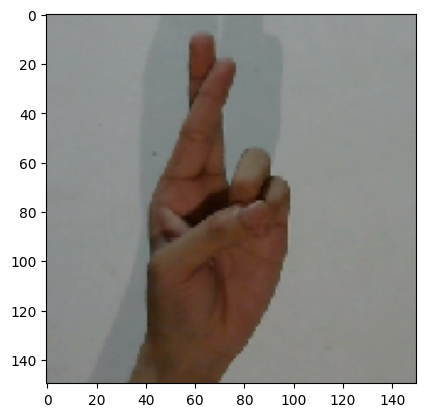

In [5]:
gambar = 'C:\FILE SEB INSTALL ULANG 7 6 2021/KULIAH/Skripsi/deep-learning/dataset_splitted/val/R/hand_343.png'
img = tf.keras.utils.load_img(gambar, target_size=(150, 150))
imgplot = plt.imshow(img)
x = tf.keras.preprocessing.image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)


image = np.vstack([x])
classes = model.predict(image, batch_size=32)

class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
print(class_name[np.argmax(classes)])